In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from copy import deepcopy

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# train_data = torchvision.datasets.MNIST(
#     './mnst_files/', train=True, download=True)

# data = train_data.data.float() / 255.0
# mean = data.mean()
# std = data.std()

In [3]:
# For reproducibility, this turns off cudnn's auto-tuner.
torch.backends.cudnn.enabled = False
torch.manual_seed(42)

# global_mean = mean.item() # MNIST train dataset mean
# global_std = std.item() # MNIST train dataset standard deviation
global_mean = 0.1307 # MNIST train dataset mean
global_std = 0.3081 # MNIST train dataset standard deviation
batch_size_train = 64
batch_size_test = 64


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((global_mean,), (global_std,)),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnst_files/', train=True, download=True,
        transform=transform),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnst_files/', train=False, download=True,
        transform=transform),
    batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 45177093.62it/s]


Extracting ./mnst_files/MNIST/raw/train-images-idx3-ubyte.gz to ./mnst_files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73326691.18it/s]


Extracting ./mnst_files/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnst_files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 14085117.72it/s]


Extracting ./mnst_files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnst_files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10648702.50it/s]

Extracting ./mnst_files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnst_files/MNIST/raw



torch.Size([64, 1, 28, 28])
torch.Size([64])


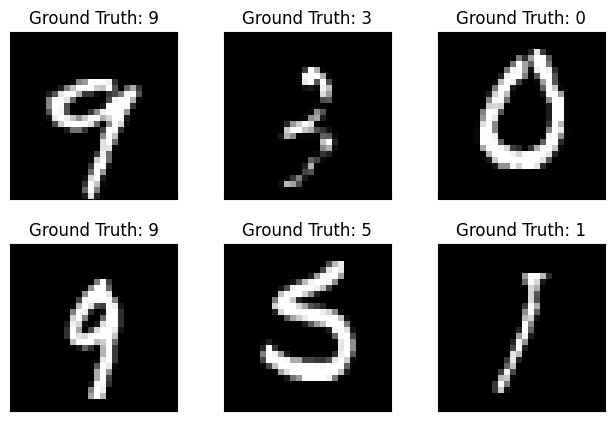

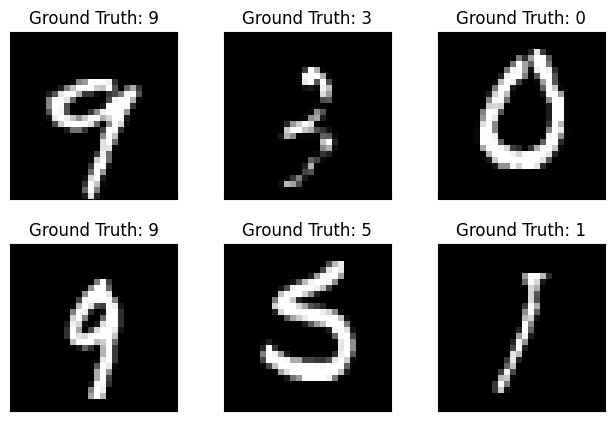

In [4]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Building the Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, input_size=1, n_classes=10, hidden_size=[50]):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=10, kernel_size=5, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.conv2_dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(320, hidden_size[0])
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size[0], n_classes)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### Define training loop

In [7]:
# Training function
def train_classification(model, data_loader, optimizer, loss_fn, device):
    model.train()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(train_loader)

    return loss_total, accuracy

# Validation function
def validate(model, data_loader, loss_fn, device):
    model.eval()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss_total += loss.item()
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(data_loader)

    return loss_total, accuracy

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    return torch.cat(predictions), accuracy


def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            y_hat = model(x)
            _, predicted = y_hat.max(1)
            predictions.append(predicted)

    return torch.cat(predictions)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model_weights = None

    def early_stop(self, validation_loss, model):
        print(f"Early Stopping counter: {self.counter} out of {self.patience}")
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 1
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [8]:
# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training parameters
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Instantiate model, loss function, and optimizer
model = ConvolutionalNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    # Training
    train_loss, train_acc = train_classification(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"[{epoch+1}/{n_epochs}] Train loss: {train_loss:.4f} acc: {train_acc:.2f}%")

    # Validation
    val_loss, val_acc = validate(model, test_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'[{epoch+1}/{n_epochs}] Val loss: {val_loss:.4f} acc: {val_acc:.2f}%')

    if early_stopper.early_stop(val_loss, model):
        early_stopper.save_best_weights(model)
        print("Patience Depleated: Early Stopping triggered.")
        break
early_stopper.restore_best_weights(model)

Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]

[1/3] Train loss: 0.7518 acc: 75.65%


Training Progress:  33%|███▎      | 1/3 [00:15<00:31, 15.92s/it]

[1/3] Val loss: 0.1378 acc: 96.12%
Early Stopping counter: 0 out of 5
[2/3] Train loss: 0.3062 acc: 90.78%


Training Progress:  67%|██████▋   | 2/3 [00:34<00:17, 17.30s/it]

[2/3] Val loss: 0.0883 acc: 97.23%
Early Stopping counter: 1 out of 5
[3/3] Train loss: 0.2343 acc: 92.89%


Training Progress: 100%|██████████| 3/3 [00:52<00:00, 17.38s/it]

[3/3] Val loss: 0.0735 acc: 97.86%
Early Stopping counter: 1 out of 5


In [10]:
save = False
if save:
    torch.save(model.state_dict(), '/results/model.pth')
    torch.save(optimizer.state_dict(), '/results/optimizer.pth')

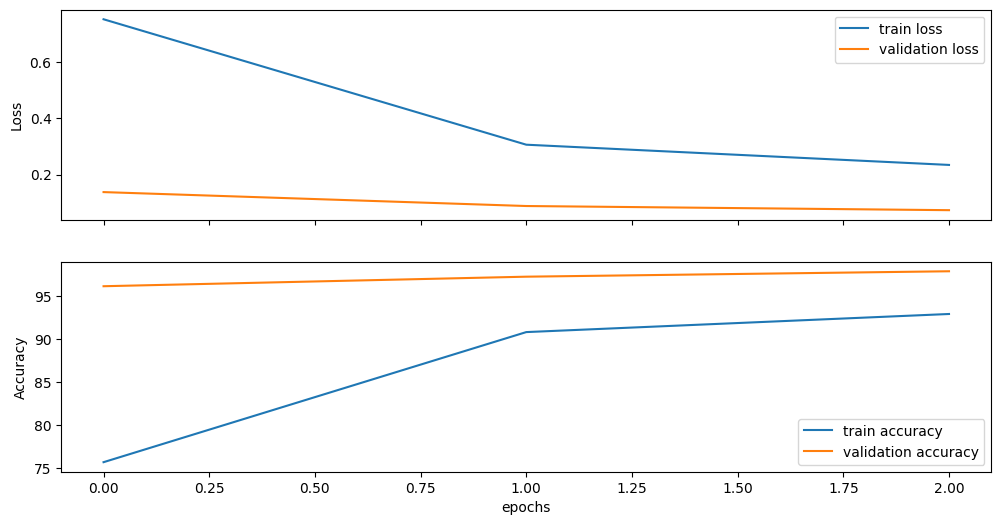

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

# Copy the tensors from GPU to CPU
train_loss_cpu = torch.Tensor(train_losses).cpu().tolist()
val_loss_cpu = torch.Tensor(val_losses).cpu().tolist()
train_acc_cpu = torch.Tensor(train_accuracies).cpu().tolist()
val_acc_cpu = torch.Tensor(val_accuracies).cpu().tolist()

ax1.plot(train_loss_cpu, label="train loss")
ax1.plot(val_loss_cpu, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_acc_cpu, label="train accuracy")
ax2.plot(val_acc_cpu, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()